<a href="https://colab.research.google.com/github/PlugRS/Time-Series-Analysis/blob/master/Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Start by Importing

In [1]:
!pip install yfinance

     |████████████████████████████████| 63 kB 1.3 MB/s 
     |████████████████████████████████| 6.4 MB 8.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import yfinance as yf

tickerSymbol = 'SPY' # S&P 500, ticker symkbol
tickerData = yf.Ticker(tickerSymbol) # get the tickers data
tickerDf = tickerData.history(period = '1d', start = '2017-1-1', end = '2022-1-1') # Get historical proces for this data
tickerDf = tickerDf[['Close']]
tickerDf.head() # see your data

,Close
Date,
2017-01-03,205.509094
2017-01-04,206.731674
2017-01-05,206.567474
2017-01-06,207.306503
2017-01-09,206.622238


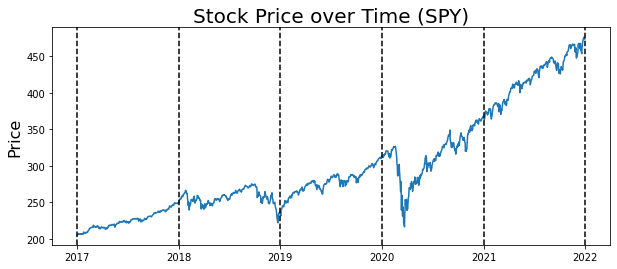

In [4]:
plt.figure(figsize=(10,4)) 
plt.plot(tickerDf.Close)
plt.title('Stock Price over Time (%s)' %tickerSymbol, fontSize = 20)
plt.ylabel('Price', fontSize = 16)
for year in range(2017,2023):
  plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle = '--')

## Stationarity

Difference of time series

In [5]:
first_diffs = tickerDf.Close.values[1:] - tickerDf.Close.values[:-1] # difference of consecutive 
first_diffs = np.concatenate([first_diffs, [0]])
tickerDf['first_difference'] = first_diffs
tickerDf.head()

,Close,first_difference
Date,,
2017-01-03,205.509094,1.222580
2017-01-04,206.731674,-0.164200
2017-01-05,206.567474,0.739029
2017-01-06,207.306503,-0.684265
2017-01-09,206.622238,0.000000


In [6]:
tickerDf.tail()

,Close,first_difference
Date,,
2021-12-27,475.781921,-0.388794
2021-12-28,475.393127,0.608124
2021-12-29,476.001251,-1.315918
2021-12-30,474.685333,-1.196289
2021-12-31,473.489044,0.000000


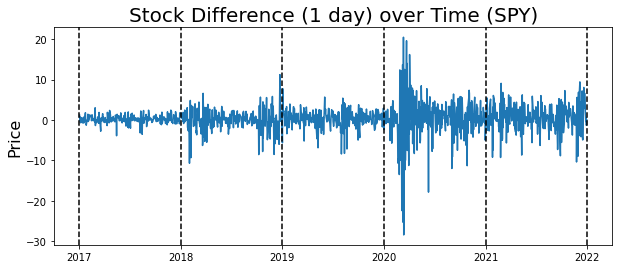

In [7]:
plt.figure(figsize=(10,4)) 
plt.plot(tickerDf.first_difference)
plt.title('Stock Difference (1 day) over Time (%s)' %tickerSymbol, fontSize = 20)
plt.ylabel('Price', fontSize = 16)
for year in range(2017,2023):
  plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle = '--')

Seems to be:

*   stationary (centered around 0).
*   volatility is high in some places.
*   Seasonal component is there.






## ACF/PACF Plots: Doesn't provide much info with the lags

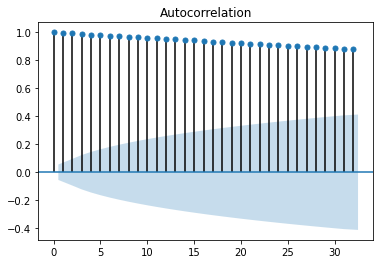

In [8]:
acf_plot = plot_acf(tickerDf.Close) 

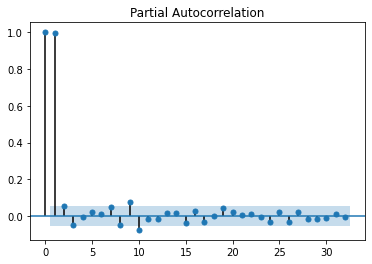

In [9]:
pacf_plot = plot_pacf(tickerDf.Close) 

## Augmented Dicky Fuller Test

In [10]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(tickerDf.Close)
print("ADF Statistic:", result[0])
print("P-Value:", result[1]) # Result (P-Value) < 0.05 then it is stationary else it's not stationary.

ADF Statistic: 0.5141702581109319
P-Value: 0.9852974853748129


AR (Auto Regressive)

From Pacf & ACF, it looks like lag(2) is best so we choose a AR(2) model

In [11]:
from statsmodels.tsa.stattools import ARMA
from pandas import datetime
from datetime import timedelta

train_end = datetime(2020,12,31)
test_end = datetime(2021,12,31)

train_data = tickerDf.Close[:train_end]
test_data = tickerDf.Close[train_end + timedelta(days=1) : test_end] # adding one day to the end of train set to make the test set

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [12]:
model = ARMA(train_data, order = (2,0)) # 2 lags in AR, 0 in MA since it's an AR model
model_fit = model.fit() # Fitting the model

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [13]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 1007
Model:                     ARMA(2, 0)   Log Likelihood               -2640.735
Method:                       css-mle   S.D. of innovations              3.322
Date:                Wed, 30 Mar 2022   AIC                           5289.470
Time:                        07:07:11   BIC                           5309.129
Sample:                             0   HQIC                          5296.939
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         280.8511     53.615      5.238      0.000     175.768     385.934
ar.L1.Close     0.7957      0.031     25.976      0.000       0.736       0.856
ar.L2.Close     0.2032      0.031      6.625    

*Here in table we get summary of important variables:*

in between, we get the **importance of each lag (ar.L1 & ar.L2)** slong with a constant (coeff.). with P values shown: more less the more better is the lag or factor. Here we can see it's 0 P-value so it's good. 

## Prediction through AR

In [24]:
tickerDf['Close']

Date
2017-01-03    205.509094
2017-01-04    206.731674
2017-01-05    206.567474
2017-01-06    207.306503
2017-01-09    206.622238
                 ...    
2021-12-27    475.781921
2021-12-28    475.393127
2021-12-29    476.001251
2021-12-30    474.685333
2021-12-31    473.489044
Name: Close, Length: 1259, dtype: float64

In [14]:
# prediction start and end dates

pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [ ]:
data_to_predict = pd.Series(input_data, index= myIndex)

In [ ]:
predictions = model_fit.predict(start = pred_start_date, end = pred_end_date) 
residuals = test_data - predictions

In [26]:
tickerDf.isnull().values.any()

False



---



# Project Start (Through Download)

In [ ]:
!pip install statsmodels

In [ ]:
v = pd.read_csv('V.csv')

In [ ]:
v.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-03-22,206.550003,212.289993,206.229996,208.000000,206.714752,11371600
1,2021-03-23,209.050003,209.960007,207.500000,208.149994,206.863831,8820700
2,2021-03-24,208.750000,211.139999,207.929993,208.070007,206.784332,10101600
3,2021-03-25,207.669998,208.820007,205.779999,207.970001,206.684937,8390800
4,2021-03-26,208.250000,213.699997,207.699997,213.529999,212.210571,7399900


In [ ]:
v['Date'] = pd.to_datetime(v.Date) # changing the default dates to python recognised datetime

In [ ]:
v.set_index('Date', inplace = True) # Putting the date column as index

In [ ]:
v.head()

## **Plot**

**Close Prices**

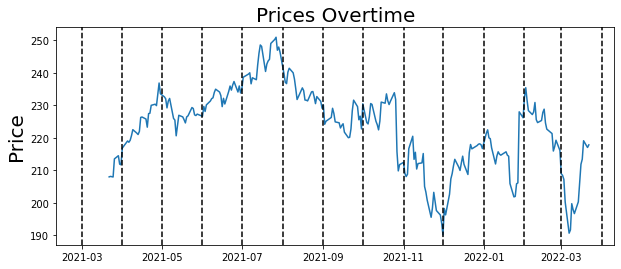

In [ ]:
# Performed on Visa

plt.figure(figsize = (10,4))
plt.plot(v.Close)
plt.title('Prices Overtime', fontsize = 20)
plt.ylabel('Price', fontsize = 20)

for months in range(3, 12):
  plt.axvline(pd.to_datetime('2021-'+ str(months) +'-01'), color = 'k', linestyle = '--')

# Looping through the 'month' numbers and putting in strings that converts to datetime values which is represented on graph (Axis).
plt.axvline(pd.to_datetime('2021-12-01'), color = 'k', linestyle = '--')

for months in range(1, 5):
    plt.axvline(pd.to_datetime('2022-'+ str(months) +'-01'), color = 'k', linestyle = '--')

# Understanding Time Series

### **ACF Plot**

Showing correlation with all past values with each other at Time T, T-1 ... T-100  at start then uncertainity increases (Blue area)

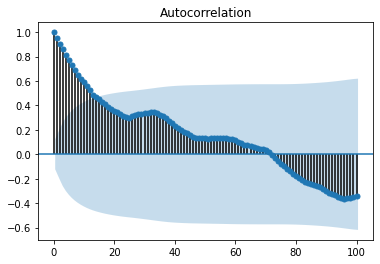

In [ ]:
acf_plot = plot_acf(v.Close, lags = 100) # Relations till 100 past values

### **PACF Plot**

Shows direct correlation with past values. Shows strong correlation at start and then starts diminishing.

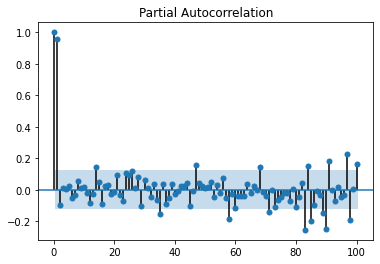

In [ ]:
pacf_plot = plot_pacf(v.Close, lags = 100) 

# **FUNCTIONS**

Lambda

In [ ]:
# Lambda functions: Takes an input and returns value through a small one liner function.
f = lambda x,y : x+1+y
f(4,6)

11

Mapping Function

In [ ]:
# .strip() removes front & trailing characters | .split divides strings into list
s = input().strip().split() 

# The map() function applies a given function to each item of an iterable (list, tuple etc.) and returns an iterator.
yo = [1,2,3,4] # LIST
adder = lambda x: x+1 # FUNCTION
added = list(map(adder,yo)) # Mapping FUNCTION to each item in LIST  & Returning the list of answers.

print(added)

[2, 3, 4, 5]


# **GRAPHS**

In [ ]:
import networkx as nx

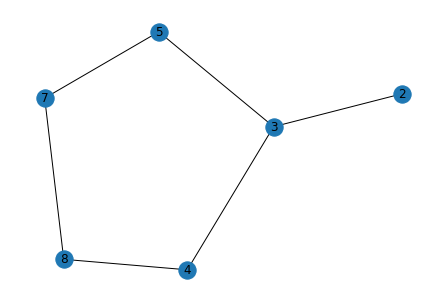

In [ ]:
graph = {
      '5' : ['3', '7'],
      '3' : ['2', '4'],
      '7' : ['8'],
      '2' : [],
      '4' : ['8'],
      '8' : []
}

G = nx.Graph(graph)  # making a graph out of dictionary
nx.draw(G, with_labels = True) # Drawing the graph

***Steps:***
- Visit Vertex.
- Explore Vertex.

***Traversal Methods:***

*Breadth First Search: Level order search uses QUEUE:*
- Keep visiting all the neighbouring nodes of vertex and then go the next node (repeat), Don't visit the visited nodes again.

*Depth First Search: Preorder search uses STACK:*
- Go to the depth of the chosen node and then come back up whilst visiting the nodes in between. 

In [ ]:
#BFS
queue.append(new_node)
queue.pop(0)

#DFS
queue.append(new_node)
queue.pop()#default pop out the -1, i.e., the last one

# ***TIME SERIES ANALYSIS***

***Generating time series***

In [ ]:
import pandas as pd

rng = pd.date_range('2019 Jul 10:15', periods = 10, freq = 'D') # Frequency: M,D: Month, Daily
rng

DatetimeIndex(['2019-07-01 10:15:00', '2019-07-02 10:15:00',
               '2019-07-03 10:15:00', '2019-07-04 10:15:00',
               '2019-07-05 10:15:00', '2019-07-06 10:15:00',
               '2019-07-07 10:15:00', '2019-07-08 10:15:00',
               '2019-07-09 10:15:00', '2019-07-10 10:15:00'],
              dtype='datetime64[ns]', freq='D')

**Time Format Types:**

```
 2022-01-31 | 2019 Jul 10:15 | 14/11/2001
```



In [ ]:
moment  = pd.Timestamp('2022-01-31 12:00:00')
moment

Timestamp('2001-11-14 00:00:00')

**Time Offsets**

*1 ns | 1 day | 1.5 hours*

In [ ]:
pd.Timestamp('1/01/2001 8:00') + pd.Timedelta('1 day')

Timestamp('2001-01-02 08:00:00')

In [ ]:
rng + pd.Timedelta('1 day')

DatetimeIndex(['2019-07-02 10:15:00', '2019-07-03 10:15:00',
               '2019-07-04 10:15:00', '2019-07-05 10:15:00',
               '2019-07-06 10:15:00', '2019-07-07 10:15:00',
               '2019-07-08 10:15:00', '2019-07-09 10:15:00',
               '2019-07-10 10:15:00', '2019-07-11 10:15:00'],
              dtype='datetime64[ns]', freq='D')

**Time Spans**

Basically a **Period represents an interval** while a **Timestamp represents a point in time.** 

Hence, in **date_range**: Timestamps are index of data rather than periods in **period_range**.

In [ ]:
p = pd.Period('14/11/2001') # prints period (day,month,year)
t = pd.Timestamp('14/11/2001') # prints whole till 00:00:00

print("Period (interval) ->",p,"| Exact point in time (timestamp) ->",t)

Period (interval) -> 2001-11-14 | Exact point in time (timestamp) -> 2001-11-14 00:00:00


In [ ]:
x = p.start_time()
y = p.end_time()

Finding the years I have been born :D

In [ ]:
rng2 = pd.period_range('14/11/2001 12:00', freq = '1Y', periods = 21 )
rng2

PeriodIndex(['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
             '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
             '2017', '2018', '2019', '2020', '2021'],
            dtype='period[A-DEC]')

In [ ]:
rng3 = pd.date_range('14/11/2001 12:00', freq = '10B12h30min', periods = 20) # B = Business Days
rng3

DatetimeIndex(['2001-11-14 12:00:00', '2001-11-29 00:30:00',
               '2001-12-13 13:00:00', '2001-12-28 01:30:00',
               '2002-01-11 14:00:00', '2002-01-26 02:30:00',
               '2002-02-08 15:00:00', '2002-02-23 03:30:00',
               '2002-03-08 16:00:00', '2002-03-23 04:30:00',
               '2002-04-05 17:00:00', '2002-04-20 05:30:00',
               '2002-05-03 18:00:00', '2002-05-18 06:30:00',
               '2002-05-31 19:00:00', '2002-06-15 07:30:00',
               '2002-06-28 20:00:00', '2002-07-13 08:30:00',
               '2002-07-26 21:00:00'],
              dtype='datetime64[ns]', freq='10B+12H30Min')

### **Making a timeseries with panda series.**

In [ ]:
table = pd.Series(range(10), pd.period_range('14/11/2001', freq = '1B', periods = 10))
table[:5]

2001-11-14    0
2001-11-15    1
2001-11-16    2
2001-11-19    3
2001-11-20    4
Freq: B, dtype: int64

In [ ]:
timestamp_table = table.to_timestamp() # Convert table data to timestamp
timestamp_table

In [ ]:
timestamp_table = timestamp_table.to_period() # Convert table data to period
timestamp_table

## **Time Zone Conversions**

In [ ]:
rng = pd.date_range('14/11/2001', freq = 'd', periods = 10)
rng 

DatetimeIndex(['2001-11-14', '2001-11-15', '2001-11-16', '2001-11-17',
               '2001-11-18', '2001-11-19', '2001-11-20', '2001-11-21',
               '2001-11-22', '2001-11-23'],
              dtype='datetime64[ns]', freq='D')

**Convert naive (no zone) Timestamp to local time zone, or remove timezone from timezone-aware Timestamp.**

In [ ]:
rng_naive = rng # no timestamp

In [ ]:
rng_timestamp = rng.tz_localize('Europe/London')

For Ambiguos data conversion (eg. Error in dates etc.) automatically correct here.

In [ ]:
rng.tz_localize('Europe/London', ambiguos = 'infer')

In [ ]:
rng_timestamp

DatetimeIndex(['2001-11-14 00:00:00+00:00', '2001-11-15 00:00:00+00:00',
               '2001-11-16 00:00:00+00:00', '2001-11-17 00:00:00+00:00',
               '2001-11-18 00:00:00+00:00', '2001-11-19 00:00:00+00:00',
               '2001-11-20 00:00:00+00:00', '2001-11-21 00:00:00+00:00',
               '2001-11-22 00:00:00+00:00', '2001-11-23 00:00:00+00:00'],
              dtype='datetime64[ns, Europe/London]', freq=None)

**Indian Time Zone**

In [ ]:
rng = pd.date_range('14/11/2001', freq = 'd', periods = 10, tz = 'Asia/Kolkata')
print(rng.tz)

Asia/Kolkata


**Convert to other time zone**

In [ ]:
rng_timestamp.tz_convert('Asia/Kolkata')
rng_timestamp

DatetimeIndex(['2001-11-14 05:30:00+05:30', '2001-11-15 05:30:00+05:30',
               '2001-11-16 05:30:00+05:30', '2001-11-17 05:30:00+05:30',
               '2001-11-18 05:30:00+05:30', '2001-11-19 05:30:00+05:30',
               '2001-11-20 05:30:00+05:30', '2001-11-21 05:30:00+05:30',
               '2001-11-22 05:30:00+05:30', '2001-11-23 05:30:00+05:30'],
              dtype='datetime64[ns, Asia/Kolkata]', freq=None)

# **Reading & Working with Time Series Data**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab

**pd.read_fwf()** function reads in fixed-width formatted text files.

In [ ]:
data = pd.read_csv('long_data_.csv')
data

,States,Regions,latitude,longitude,Dates,Usage
0,Punjab,NR,31.519974,75.980003,02/01/2019 00:00:00,119.9
1,Haryana,NR,28.450006,77.019991,02/01/2019 00:00:00,130.3
2,Rajasthan,NR,26.449999,74.639981,02/01/2019 00:00:00,234.1
3,Delhi,NR,28.669993,77.230004,02/01/2019 00:00:00,85.8
4,UP,NR,27.599981,78.050006,02/01/2019 00:00:00,313.9
...,...,...,...,...,...,...
16594,Manipur,NER,24.799971,93.950017,05/12/2020 00:00:00,2.5
16595,Meghalaya,NER,25.570492,91.880014,05/12/2020 00:00:00,5.8
16596,Mizoram,NER,23.710399,92.720015,05/12/2020 00:00:00,1.6
16597,Nagaland,NER,25.666998,94.116570,05/12/2020 00:00:00,2.1


In [ ]:
data['States'].value_counts()

In [ ]:
UP = []
UP = pd.DataFrame(UP)
date = []
date = pd.DataFrame(date)

In [ ]:
data.loc[[0],['Dates', 'Usage']]

,Dates,Usage
16598,05/12/2020 00:00:00,3.3


We want only UP

In [ ]:
for i in range(len(data)):
  if data["States"][i] == "UP":
    UP.append(data['Usage'][i])
    date.append(data['date'][i])

In [ ]:
UP

""


## Formatting Data

In [ ]:
data = pd.read_csv('dataset_tk.csv')
data

In [ ]:
string = 'Punjab Haryana Rajasthan Delhi	UP	Uttarakhand	HP	J&K	Chandigarh	Chhattisgarh	Gujarat	MP	Maharashtra	Goa	DNH	Andhra_Pradesh	Telangana	Karnataka	Kerala	Tamil_Nadu	Pondy	Bihar	Jharkhand	Odisha	West_Bengal	Sikkim	Arunachal_Pradesh	Assam	Manipur	Meghalaya	Mizoram	Nagaland	Tripura'
x = string.split() # splits the spaces in string into seperate string in a list.

In [ ]:
x.insert(0, 'dates') # inserting at any position: here inserting string 'dates' at 0th index.
len(x)

In [ ]:
data.columns = x # assigning column names
data

In [ ]:
print(data['dates'].dtypes) # Type of data of the 'date'

object


# Converting object to datetime for time series analysis.

In [ ]:
data['dates'] = pd.to_datetime(data['dates']) 

In [ ]:
data[:3]

,dates,Punjab,Haryana,Rajasthan,Delhi,UP,Uttarakhand,HP,J&K,Chandigarh,Chhattisgarh,Gujarat,MP,Maharashtra,Goa,DNH,Andhra_Pradesh,Telangana,Karnataka,Kerala,Tamil_Nadu,Pondy,Bihar,Jharkhand,Odisha,West_Bengal,Sikkim,Arunachal_Pradesh,Assam,Manipur,Meghalaya,Mizoram,Nagaland,Tripura
0,2019-02-01,119.9,130.3,234.1,85.8,313.9,40.7,30.0,52.5,5.0,78.7,319.5,253.0,428.6,12.8,18.6,164.6,204.2,206.3,72.7,268.3,6.3,82.3,24.8,70.2,108.2,2.0,2.1,21.7,2.7,6.1,1.9,2.2,3.4
1,2019-03-01,121.9,133.5,240.2,85.5,311.8,39.3,30.1,54.1,4.9,78.8,316.7,253.6,419.6,13.7,18.2,170.1,204.5,212.2,73.6,285.2,6.5,82.0,25.6,67.9,110.2,1.9,2.2,23.4,2.4,6.5,1.8,2.2,3.6
2,2019-04-01,118.8,128.2,239.8,83.5,320.7,38.1,30.1,53.2,4.8,74.8,301.9,239.3,395.8,12.6,16.7,165.2,201.2,205.3,73.4,270.3,6.4,82.9,26.3,66.3,106.8,1.7,2.2,21.7,2.4,6.3,1.7,2.2,3.5


**To GET Specific Columns**

In [ ]:
UP = data.loc[:, ['dates','UP']] # loc can be used to put in column names

# UP = data.ioc[:, [0,1]] <-- Put in required indexes

***OR***

In [ ]:
UP.DataFrame(data['UP'])
UP.insert(0, 'dates', data['dates'])
print(UP['dates'].dtypes)

datetime64[ns]


In [ ]:
UP.set_index('dates') # setting date as index

,UP
dates,
2019-02-01,313.9
2019-03-01,311.8
2019-04-01,320.7
2019-05-01,299.0
2019-06-01,286.8
...,...
2020-01-12,322.8
2020-02-12,331.4
2020-03-12,336.7


In [ ]:
print(UP['dates'].dtypes)

datetime64[ns]


In [ ]:
UP.describe()

,UP
count,503.000000
mean,314.036382
std,66.516960
min,186.800000
25%,263.650000
50%,290.000000
75%,370.550000
max,471.800000


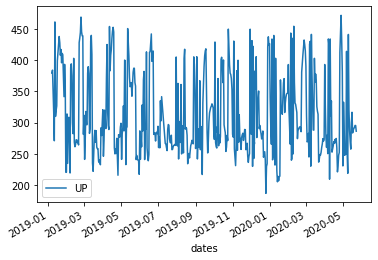

In [ ]:
UP[:50].plot(x ='dates') # Wihout sepcifying axis it's giving error idk why

# Moving Window Function